In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick

from epitools import between_p, within_p

In [2]:
from random import sample

In [3]:
sample([3, 2, 1], 2)

[3, 1]

In [4]:
VOTES_POLLING = 0
RATE_THRESHOLD = 0
output = []

boostrap = True

for country, year, election in [
    ("France", 2002, "first_round"),
    ("France", 2007, "first_round"),
    ("France", 2012, "first_round"),
    ("France", 2017, "first_round"),
    ("France", 2022, "first_round"),
    ("United States", 2000, "first_round"),
    ("United States", 2004, "first_round"),
    ("United States", 2008, "first_round"),
    ("United States", 2012, "first_round"),
    ("United States", 2016, "first_round"),
    ("United States", 2020, "first_round"),
    ("Chile", 2013, "first_round"),
    ("Chile", 2017, "first_round"),
    ("Chile", 2021, "first_round")
]:
    print(country, year)
    df = pd.read_csv(f"data_output/{country}/{year}_{election}.csv.gz")
    if "flag_candidates" in list(df):
        df = df[df["flag_candidates"] == 1]

    ee = df.groupby("polling_id").agg({"value": "sum"})
    dd = df.groupby("candidate").agg({"value": "sum"})
    dd["rate"] = dd.apply(lambda x: x/x.sum())
    dd = dd.sort_values("rate", ascending=False)

    if country == "United States":
        values = list(dd.head(2).index.unique())
    elif country == "France":
        values = list(dd.head(8).index.unique())
    elif country == "Chile":
        values = list(dd.head(4).index.unique())

    df = df[df["candidate"].isin(values)].copy()

    tt = df.groupby(["polling_id", "candidate"]).agg({"value": "sum"})
    tt["rate"] = tt.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
    tt = tt.reset_index()

    df = tt.copy()

    N = len(df["candidate"].unique())
    units = list(df["polling_id"].unique())
    N_units = len(units)
    

    for iteration in range(30):
        smpl = sample(units, int(N_units/2))
        df_frag = df[df["polling_id"].isin(smpl)].copy()

        df_a = between_p(df_frag)
        df_b = within_p(df_frag)

        data = pd.merge(df_a, df_b, on=["candidate"])

        output.append({
            "country": country,
            "year": year,
            "iteration": iteration,
            "N": N,
            "N_units": N_units,
            "value": np.sum((data["value_x"] + data["value_y"])),
            "between": np.sum(data["value_x"]),
            "within": np.sum(data["value_y"])
        })

df = pd.DataFrame(output)
df

France 2002
France 2007
France 2012
France 2017
France 2022
United States 2000
United States 2004
United States 2008
United States 2012
United States 2016
United States 2020
Chile 2013
Chile 2017
Chile 2021


,country,year,iteration,N,N_units,value,between,within
0,France,2002,0,8,64141,0.935196,0.892496,0.042700
1,France,2002,1,8,64141,0.935241,0.892196,0.043045
2,France,2002,2,8,64141,0.935231,0.892167,0.043064
3,France,2002,3,8,64141,0.935211,0.892014,0.043197
4,France,2002,4,8,64141,0.935154,0.892310,0.042844
...,...,...,...,...,...,...,...,...
415,Chile,2021,25,4,46639,0.930691,0.809639,0.121052
416,Chile,2021,26,4,46639,0.931140,0.809032,0.122109
417,Chile,2021,27,4,46639,0.930734,0.809782,0.120952
418,Chile,2021,28,4,46639,0.930802,0.809841,0.120961


In [5]:
dfa = pd.read_csv(f"data_output/France/2017_first_round.csv.gz")
dfb = pd.read_csv(f"data_output/France/2022_first_round.csv.gz")

In [6]:
len(set(dfa.polling_id)), len(set(dfb.polling_id))

(35892, 69682)

In [7]:
def get_data_from_worldbank(PATH, measure_name):
    output_df = pd.read_excel(PATH, header=3)
    output_df = output_df[["Country Name"] + list(map(str, list(range(1960, 2021 + 1))))]
    output_df = output_df.rename(columns={"Country Name": "country"})
    output_df = output_df.melt(id_vars=["country"], var_name="year", value_name=measure_name)
    output_df = output_df.dropna().reset_index(drop=True)
    output_df["year"] = output_df["year"].astype(int)

    custom_df_2022 = output_df[output_df["year"] == 2021].copy()
    custom_df_2022["year"] = 2022
    return pd.concat([output_df, custom_df_2022])

In [8]:
df_gdp_per_capita = get_data_from_worldbank(
    "data_worldbank/API_NY.GDP.PCAP.PP.KD_DS2_en_excel_v2_4770533.xls", 
    measure_name="gdp_per_capita"
)
df_gdp_per_capita.tail()


,country,year,gdp_per_capita
7412,Samoa,2022,5534.126958
7413,Kosovo,2022,11884.179915
7414,South Africa,2022,13311.925699
7415,Zambia,2022,3236.788981
7416,Zimbabwe,2022,2115.144555


In [9]:
df_gini = get_data_from_worldbank(
    "data_worldbank/API_SI.POV.GINI_DS2_en_excel_v2_4770509.xls", 
    measure_name="gini"
)
df_gini.head()

,country,year,gini
0,Sweden,1967,34.0
1,United Kingdom,1969,33.7
2,Canada,1971,37.3
3,United Kingdom,1974,30.0
4,United States,1974,35.3


In [10]:
df_unemployment = get_data_from_worldbank(
    "data_worldbank/API_SL.UEM.TOTL.NE.ZS_DS2_en_excel_v2_4770856.xls", 
    measure_name="unemployment"
)
df_unemployment.head()

,country,year,unemployment
0,Japan,1960,1.7
1,United States,1960,5.5
2,Japan,1961,1.4
3,United States,1961,6.7
4,Japan,1962,1.3


In [11]:
df_population = get_data_from_worldbank(
    "data_worldbank/API_SP.POP.TOTL_DS2_en_excel_v2_4770385.xls", 
    measure_name="population"
)
df_population.tail()

,country,year,population
16395,Kosovo,2022,1786038.0
16396,"Yemen, Rep.",2022,32981641.0
16397,South Africa,2022,59392255.0
16398,Zambia,2022,19473125.0
16399,Zimbabwe,2022,15993524.0


In [12]:
df_rural_population = get_data_from_worldbank(
    "data_worldbank/API_SP.RUR.TOTL.ZS_DS2_en_excel_v2_4773326.xls", 
    measure_name="rural_population"
)
df_rural_population.tail()

,country,year,rural_population
16301,Samoa,2022,82.258
16302,"Yemen, Rep.",2022,61.454
16303,South Africa,2022,32.153
16304,Zambia,2022,54.808
16305,Zimbabwe,2022,67.697


In [13]:
df_model = df.copy()
for dt in [df_gdp_per_capita, df_gini, df_unemployment, df_population, df_rural_population]:
    df_model = pd.merge(dt, df_model, on=["country", "year"])
    
df_model.to_csv("test.csv")

In [14]:
df

,country,year,iteration,N,N_units,value,between,within
0,France,2002,0,8,64141,0.935196,0.892496,0.042700
1,France,2002,1,8,64141,0.935241,0.892196,0.043045
2,France,2002,2,8,64141,0.935231,0.892167,0.043064
3,France,2002,3,8,64141,0.935211,0.892014,0.043197
4,France,2002,4,8,64141,0.935154,0.892310,0.042844
...,...,...,...,...,...,...,...,...
415,Chile,2021,25,4,46639,0.930691,0.809639,0.121052
416,Chile,2021,26,4,46639,0.931140,0.809032,0.122109
417,Chile,2021,27,4,46639,0.930734,0.809782,0.120952
418,Chile,2021,28,4,46639,0.930802,0.809841,0.120961


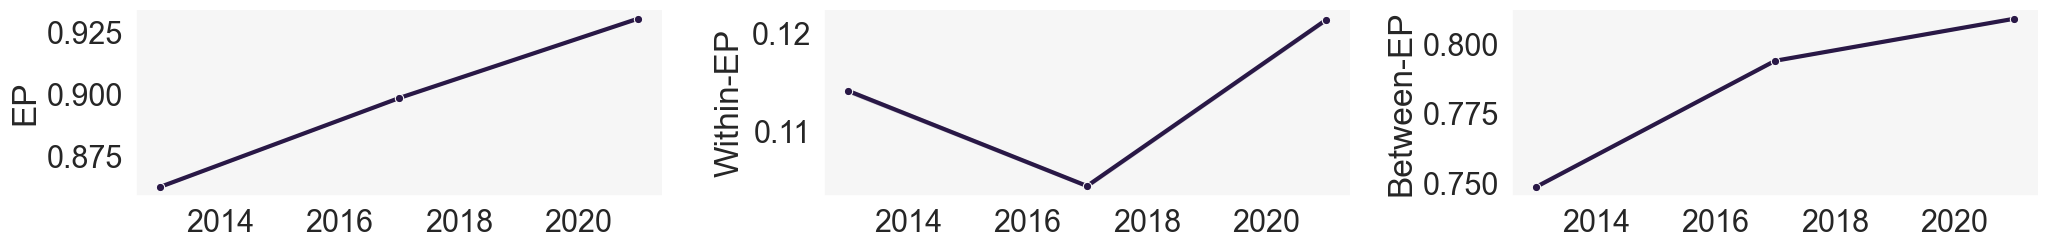

In [15]:
# sns.set(font_scale=1.5)
data = df[df["country"] == "Chile"]
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 3))

sns.lineplot(x="year", y="value", marker="o", color="#291846", lw=3, data=data, ax=axs[0])
axs[0].set_ylabel("EP")
# axs[0].set_ylim(0.9, 1.05)

sns.lineplot(x="year", y="within", marker="o", color="#291846", lw=3, data=data, ax=axs[1])
axs[1].set_ylabel("Within-EP")
# axs[1].set_ylim(0, data.within.max())

sns.lineplot(x="year", y="between", marker="o", color="#291846", lw=3, data=data, ax=axs[2])
axs[2].set_ylabel("Between-EP")
# axs[2].set_ylim(0, data.between.max())


for i in range(3):
    ax = axs[i]
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_xlabel("")
    sns.despine()
fig.tight_layout()

In [16]:
data.groupby("year").mean()

C:\Users\cnava\AppData\Local\Temp\ipykernel_31296\1096391150.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby("year").mean()


,iteration,N,N_units,value,between,within
year,,,,,,
2013,14.5,4.0,41349.0,0.862725,0.748588,0.114137
2017,14.5,4.0,42890.0,0.898624,0.794171,0.104453
2021,14.5,4.0,46639.0,0.930713,0.809359,0.121354


In [19]:
past = 0.748588
present = 0.809359
(present - past)/past

0.08118083645476552